In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install -U trl transformers datasets peft accelerate bitsandbytes evaluate bert-score rouge_score --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 6.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━

In [ ]:
from huggingface_hub import login

login(token="My secret token")

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model_name = "mistralai/Mistral-7B-Instruct-v0.1"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, device_map="auto")


tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

2025-05-14 23:20:13.463403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747264813.653529      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747264813.707363      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)


In [ ]:
from datasets import load_dataset

dataset = load_dataset("tatsu-lab/alpaca", split="train[:2000]")

In [ ]:
instruction = "Please respond appropriately to the following user instruction."

chat_template = """<|begin_of_text|>
{% for message in messages %}
<|start_header_id|>{{ message['role'] }}<|end_header_id|>
{{ message['content'] }}<|eot_id|>
{% endfor %}"""

def format_chat(row):
    messages = [
        {"role": "system", "content": instruction},
        {"role": "user", "content": row["input"]},
        {"role": "assistant", "content": row["output"]}
    ]
    row["text"] = tokenizer.apply_chat_template(
        messages,
        chat_template=chat_template,
        tokenize=False
    )
    return row

dataset = dataset.map(format_chat, num_proc=4)

Map (num_proc=4):   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

In [ ]:
import torch, gc
from tqdm import tqdm
from evaluate import load
from bert_score import score as bert_score

rouge = load("rouge")

def simple_f1(pred, label):
    pred_tokens = pred.split()
    label_tokens = label.split()
    common = set(pred_tokens) & set(label_tokens)

    if len(common) == 0:
        return 0.0

    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(label_tokens)

    if precision + recall == 0:
        return 0.0

    return 2 * (precision * recall) / (precision + recall)

rouge = load("rouge")

def evaluate_model(model, tokenizer, dataset, max_new_tokens=100, batch_size=16):
    model.eval()
    results = []
    f1_scores = []
    rouge_preds = []
    rouge_labels = []

    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset[i:i+batch_size]

        tokenizer.padding_side = "left"
        inputs = tokenizer(
            batch["text"],
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=tokenizer.model_max_length,
        ).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_new_tokens=max_new_tokens,
                do_sample=False,
            )

        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        decoded_labels = batch["output"]

        for pred, label in zip(decoded_preds, decoded_labels):
            pred_clean = pred.strip()
            label_clean = label.strip()

            f1 = simple_f1(pred_clean, label_clean)
            f1_scores.append(f1)

            rouge_preds.append(pred_clean)
            rouge_labels.append(label_clean)

            results.append({
                "prediction": pred_clean,
                "reference": label_clean,
                "f1": f1,
            })

        del inputs, outputs
        torch.cuda.empty_cache()
        gc.collect()

    avg_f1 = sum(f1_scores) / len(f1_scores)

    rouge_result = rouge.compute(predictions=rouge_preds, references=rouge_labels)
    rougeL = rouge_result["rougeL"]

    P, R, F1 = bert_score(rouge_preds, rouge_labels, lang="en", device="cpu", verbose=False)
    avg_bert_f1 = F1.mean().item()

    print(f"\n Average F1 Score:     {avg_f1:.4f}")
    print(f" ROUGE-L Score:        {rougeL:.4f}")
    print(f" BERTScore (F1):       {avg_bert_f1:.4f}")

    return {
        "f1": avg_f1,
        "rougeL": rougeL,
        "bertscore_f1": avg_bert_f1,
        "results": results
    }

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

def tokenize(batch):
    full_texts = [f"### Instruction:\n{p}\n\n### Response:\n{o}" for p, o in zip(batch["input"], batch["output"])]
    return tokenizer(full_texts, truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize, batched=True)



Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
tokenizer.model_max_length = 1024

In [ ]:
metrics_before = evaluate_model(model, tokenizer, eval_dataset, max_new_tokens=60)

100%|██████████| 13/13 [07:09<00:00, 33.07s/it]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Average F1 Score:     0.4177
 ROUGE-L Score:        0.4108
 BERTScore (F1):       0.8384


In [ ]:
tokenizer.truncation_side = "left"
tokenizer.model_max_length = 1024

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from trl import SFTTrainer, SFTConfig

training_args = SFTConfig(
    output_dir="mistral-symbolic-ft",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    learning_rate=2e-4,
    num_train_epochs=1,
    optim="paged_adamw_32bit",
    fp16=True,
    bf16=False,
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="no",
    report_to="none"
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=lora_config,
    args=training_args,
)

trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Converting train dataset to ChatML:   0%|          | 0/1800 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/1800 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1800 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1800 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/200 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,0.899400
20,0.596000
30,0.609200
40,0.642200
50,0.558000
60,0.578400
70,0.558700
80,0.565300
90,0.556300
100,0.531900


TrainOutput(global_step=225, training_loss=0.5690294573042127, metrics={'train_runtime': 3237.7517, 'train_samples_per_second': 0.556, 'train_steps_per_second': 0.069, 'total_flos': 1.868474063536128e+16, 'train_loss': 0.5690294573042127})

In [ ]:
metrics_after = evaluate_model(model, tokenizer, eval_dataset, max_new_tokens=60)

100%|██████████| 13/13 [02:16<00:00, 10.46s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Average F1 Score:     0.4700
 ROUGE-L Score:        0.4845
 BERTScore (F1):       0.8535


In [ ]:
print("Evaluation AFTER fine-tuning:")
print(f"F1 Score:        {metrics_after['f1']:.4f}")
print(f"ROUGE-L Score:   {metrics_after['rougeL']:.4f}")
print(f"BERTScore (F1):  {metrics_after['bertscore_f1']:.4f}")

Evaluation AFTER fine-tuning:
F1 Score:        0.4700
ROUGE-L Score:   0.4845
BERTScore (F1):  0.8535


           Metric  Before Fine-Tuning  After Fine-Tuning
0        F1 Score              0.4177             0.4700
1   ROUGE-L Score              0.4108             0.4845
2  BERTScore (F1)              0.8384             0.8535


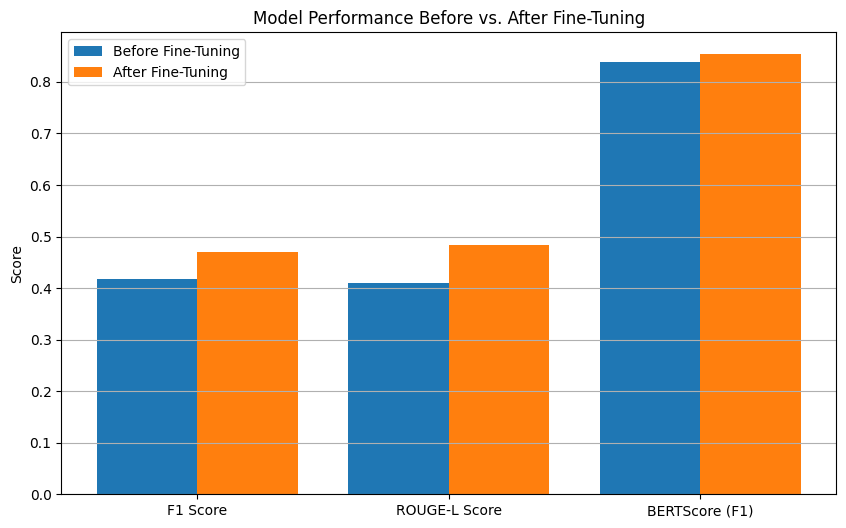

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

metrics = ["F1 Score", "ROUGE-L Score", "BERTScore (F1)"]
before = [0.4177, 0.4108, 0.8384]
after = [0.4700, 0.4845, 0.8535]

comparison_df = pd.DataFrame({
    "Metric": metrics,
    "Before Fine-Tuning": before,
    "After Fine-Tuning": after
})

print(comparison_df)

plt.figure(figsize=(10, 6))
x = range(len(metrics))
plt.bar(x, before, width=0.4, label='Before Fine-Tuning', align='center')
plt.bar([p + 0.4 for p in x], after, width=0.4, label='After Fine-Tuning', align='center')
plt.xticks([p + 0.2 for p in x], metrics)
plt.ylabel("Score")
plt.title("Model Performance Before vs. After Fine-Tuning")
plt.legend()
plt.grid(axis='y')
plt.show()
